In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

Resources:
- **Equation of motion (N-S)**: Transport. Phenomena. Second Edition. R. Byron Bird. Warren E. Stewart. Edwin N. Lightfoot.
- **Poisson Pressure Equation**: http://www.thevisualroom.com/poisson_for_pressure.html
- **CFD solver guide**: https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf


# Cavity Flow
- Incompressible Newtonian fluid (DENSITY, VISCOSITY const)
    - *Navier Stokes equation* for incompressible fluid
    - Discretization: Finite Difference Method (Central)

Govern Equations:
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\bigg(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\bigg)$$
$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\bigg(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\bigg)$$
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = -\rho\bigg(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\bigg) + \rho\frac{\partial}{\partial t}\bigg(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\bigg)$$

Discretization
- Central difference (explicit)

$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = b$$
$$\frac{p_{i+1,j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i,j-1}^n}{\Delta y^2} = b$$
$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n) + \Delta x^2(p_{i,j+1}^n+p_{i,j-1}^n) - b\Delta y^2\Delta x^2}{2(\Delta x^2+\Delta y^2)}$$

I.C.:

$u,v,p=0$

B.C.:
- Pressure Boundary Conditions: Homogeneous Neumann Boundary (Top homogeneous Dirichlet BC)

$u=1 \ at \ y=2$

$u,v=0 \ \text{on the other boundaries}$

$\frac{\partial p}{\partial y}=0 \ at \ y=0$

$p=0 \ at \ y=2$

$\frac{\partial p}{\partial x}=0 \ at \ x=0,2$

In [53]:
# Discretion
## Central Diference

def central_ddx(f, dx):
    """
    Compute central difference
    """
    diff = np.zeros_like(f)
    diff[1:-1,1:-1] = (f[1:-1,2:] - f[1:-1,:-2])/(2*dx)
    return diff

def central_ddy(f, dy):
    """
    Compute central difference
    """
    diff = np.zeros_like(f)
    diff[1:-1,1:-1] = (f[2:,1:-1] - f[:-2,1:-1])/(2*dy)
    return diff

def laplace(f, dx, dy):
    diff = np.zeros_like(f)
    diff[1:-1,1:-1] = (f[1:-1,2:] -2*f[1:-1,1:-1] +f[1:-1,:-2])/dx**2 + \
        (f[2:,1:-1] -2*f[1:-1,1:-1] +f[:-2,1:-1])/dy**2 
    return diff


In [54]:
NX = 41
NY = 41
LX = 2.0
LY = 2.0
dx = LX / (NX - 1)
dy = LY / (NY - 1)

nt = 500

rho = 1
nu = .1
dt = .001


# KINEMATIC_VISCOSITY = 0.05
U_TOP = 1.0

# dt = min(0.25*dx*dx/KINEMATIC_VISCOSITY, 4.0*KINEMATIC_VISCOSITY/U_TOP/U_TOP)

u = np.zeros((NY, NX))
v = np.zeros((NY, NX))
p = np.zeros((NY, NX))


$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n) + \Delta x^2(p_{i,j+1}^n+p_{i,j-1}^n) - b\Delta y^2\Delta x^2}{2(\Delta x^2+\Delta y^2)}$$
$$b = -\rho\bigg(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\bigg) + \rho\frac{\partial}{\partial t}\bigg(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\bigg)$$

In [55]:
def pressure_poisson(p, dx, dy, rho, dt, u, v):
    pn = np.empty_like(p)
    # pn = p.copy()
    it = 0
    max_it = 50
    err = 1e5
    tol = 1e-3

    b = np.empty_like(p)
    b = - rho*(central_ddx(u, dx)**2 + 
                           2*central_ddy(u, dy)*central_ddx(v, dx) + 
                           central_ddy(v, dy)**2) + \
                            rho/dt*(central_ddx(u, dx) + central_ddy(v, dy))

    for it in range(max_it):
        pn = p.copy()
  
        p[1:-1,1:-1] = (dy**2*(pn[1:-1,2:] + pn[1:-1,:-2]) + \
                        dx**2*(pn[2:,1:-1] + pn[:-2,1:-1]) - \
                            b[1:-1, 1:-1]*(dy**2)*(dx**2)) /(2*dx**2 + 2*dy**2)
        
        p[:, -1] = p[:, -2] # dp/dx = 0 at right
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at the top
        # it+=1

    return p

In [56]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu, U_TOP):
    un = np.empty_like(u)
    vn = np.empty_like(v)

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        p = pressure_poisson(p, dx, dy, rho, dt, un, vn)

        u = un + dt*(-central_ddx(un*un, dx) -central_ddy(vn*un, dy) - 1/rho*central_ddx(p, dx) + \
            nu*laplace(un,dx,dy))
        v = vn + dt*(-central_ddx(un*vn, dx) -central_ddy(vn*vn, dy) - 1/rho*central_ddy(p, dy) + \
            nu*laplace(vn,dx,dy))
        
        # bottom
        u[0,:] = 0.0 
        v[0,:] = 0.0     
        # top wall    
        u[-1,:] = U_TOP
        v[-1,:] = 0.0
        # left wall
        u[:,0] = 0.0
        v[:,0] = 0.0
        # right wall
        u[:,-1] = 0.0
        v[:,-1] = 0.0
        
    return u, v, p
        


    

In [57]:
u = np.zeros((NY, NX))
v = np.zeros((NY, NX))
p = np.zeros((NY, NX))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu, U_TOP)

In [58]:
# u,v,p
p

array([[-0.06510628, -0.06510628, -0.06543825, ...,  0.06271358,
         0.0623828 ,  0.0623828 ],
       [-0.06510628, -0.06510628, -0.06543825, ...,  0.06271358,
         0.0623828 ,  0.0623828 ],
       [-0.06477661, -0.06477661, -0.06511574, ...,  0.06239185,
         0.06205389,  0.06205389],
       ...,
       [-1.38546081, -1.38546081, -0.98487245, ...,  1.00676065,
         1.43397438,  1.43397438],
       [-3.04149616, -3.04149616, -1.91652058, ...,  2.00140164,
         3.20890244,  3.20890244],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

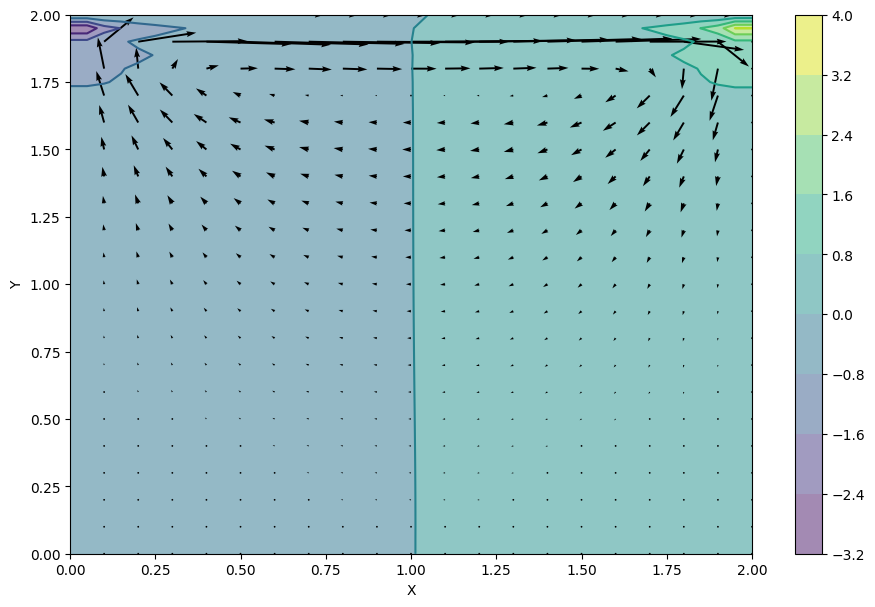

In [59]:
x = np.linspace(0, LX, NX)
y = np.linspace(0, LY, NY)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');